## Importing packages and data

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb ##download xgboost using "pip3 install xgboost"
from datetime import datetime

#data = pd.read_csv('form_responses.csv')

# pip install sdv to download sdv package

## Loading data

In [6]:
data = pd.read_csv('cleaned_routes.csv')
data

,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,coverage,crowdedness
0,A2,Opp NUSS,Ventus,Monday,09:30:00,15 - 20 minutes,Neutral,Neutral,Very Satisfied,Satisfied,Satisfied,3.0
1,D2,KR MRT,UTown,Monday,09:30:00,10 - 15 minutes,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,4.0
2,A2,KR Bus Terminal,S17,Thursday,17:50:00,< 5 minutes,Very Satisfied,Satisfied,Satisfied,Satisfied,Very Satisfied,4.0
3,A1,PGP Terminal,CLB,Friday,11:30:00,10 - 15 minutes,Very Satisfied,Very Satisfied,Very Satisfied,Neutral,Very Satisfied,4.0
4,A1,KR MRT,LT27,Tuesday,07:50:00,< 5 minutes,Neutral,Satisfied,Satisfied,Satisfied,Satisfied,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,K,S17,Opp KR MRT,Wednesday,12:45:00,< 5 minutes,Neutral,Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,3.0
236,K,S17,Opp KR MRT,Thursday,12:45:00,< 5 minutes,Neutral,Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,3.0
237,K,S17,Opp KR MRT,Friday,12:45:00,< 5 minutes,Neutral,Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,3.0
238,BTC (Bukit Timah Campus),LT27,UTown,Tuesday,19:00:00,5 - 10 minutes,Very Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,Very Satisfied,4.0


## Creating metadata

### for routes only

In [7]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data = data,
    table_name='transport')

metadata.update_column(
    column_name='time_start',
    sdtype='datetime',
    datetime_format= '%H:%M:%S')

metadata.validate()

metadata

{
    "tables": {
        "transport": {
            "columns": {
                "ISB_Service": {
                    "sdtype": "categorical"
                },
                "bus_stop_board": {
                    "sdtype": "categorical"
                },
                "bus_stop_alight": {
                    "sdtype": "categorical"
                },
                "day_of_the_week": {
                    "sdtype": "categorical"
                },
                "time_start": {
                    "sdtype": "datetime",
                    "datetime_format": "%H:%M:%S"
                },
                "travel_duration": {
                    "sdtype": "categorical"
                },
                "frequency": {
                    "sdtype": "categorical"
                },
                "punctuality": {
                    "sdtype": "categorical"
                },
                "cleanliness": {
                    "sdtype": "categorical"
                },
          

## Utilising GaussianCopulaSynthesizer

In [8]:
from sdv.single_table import GaussianCopulaSynthesizer

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.load_custom_constraint_classes(filepath='custom_constraints.py', class_names=['BusStopsCheck', 'TimeCheck'])

route_constraint = {
    'constraint_class': 'BusStopsCheck',
    'constraint_parameters': {
        'column_names':['ISB_Service', 'bus_stop_board', 'bus_stop_alight']
    }
}
time_constraint = {
    'constraint_class': 'TimeCheck',
    'constraint_parameters': {
        'column_names':['time_start']
    }
}

synthesizer.add_constraints(constraints=[route_constraint, time_constraint])

synthesizer.fit(data)

synthetic_data = synthesizer.sample(num_rows=60000)

synthetic_data

c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Sampling rows: 100%|██████████| 60000/60000 [00:58<00:00, 1026.81it/s]


,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,coverage,crowdedness
0,A1,KR MRT,CLB,Sunday,14:37:27,10 - 15 minutes,Neutral,Neutral,Very Satisfied,Dissatisfied,Dissatisfied,3.0
1,D2,KR MRT,PGP Foyer,Wednesday,16:54:16,5 - 10 minutes,Satisfied,Satisfied,Neutral,Neutral,Satisfied,4.0
2,D1,IT,UTown,Friday,09:31:18,10 - 15 minutes,Dissatisfied,Satisfied,Satisfied,Neutral,Satisfied,2.0
3,K,KR MRT,Opp KR MRT,Monday,15:15:07,10 - 15 minutes,Neutral,Dissatisfied,Satisfied,Satisfied,Satisfied,3.0
4,D2,KR MRT,LT27,Wednesday,13:47:24,15 - 20 minutes,Dissatisfied,Satisfied,Satisfied,Neutral,Satisfied,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,D2,PGP Terminal,COM3,Monday,19:51:46,< 5 minutes,Satisfied,Neutral,Satisfied,Neutral,Satisfied,5.0
59996,D2,COM3,Opp KR MRT,Wednesday,10:02:12,5 - 10 minutes,Neutral,Neutral,Very Satisfied,Neutral,Satisfied,5.0
59997,D2,KR MRT,UTown,Tuesday,13:32:51,5 - 10 minutes,Satisfied,Neutral,Very dissatisfied,Satisfied,Satisfied,5.0
59998,A1,KR MRT,CLB,Monday,13:09:12,10 - 15 minutes,Dissatisfied,Very dissatisfied,Satisfied,Very dissatisfied,Satisfied,5.0


In [9]:
synthesizer.get_learned_distributions()

{'ISB_Service': {'distribution': 'beta',
  'learned_parameters': {'loc': 0.0018189067846163393,
   'scale': 0.9944271200036984,
   'a': 1.0252890402973334,
   'b': 1.0453323543870092}},
 'bus_stop_board': {'distribution': 'beta',
  'learned_parameters': {'loc': 0.0017249520744794474,
   'scale': 0.9979452703296249,
   'a': 1.0091479685784615,
   'b': 0.9841084752516933}},
 'bus_stop_alight': {'distribution': 'beta',
  'learned_parameters': {'loc': 0.0005655220679178535,
   'scale': 0.997360913009132,
   'a': 0.9170772958964397,
   'b': 0.9146093519988884}},
 'day_of_the_week': {'distribution': 'beta',
  'learned_parameters': {'loc': 9.685945070865307e-05,
   'scale': 0.9976863249142665,
   'a': 0.943282134181886,
   'b': 0.9526487631648612}},
 'time_start': {'distribution': 'beta',
  'learned_parameters': {'loc': -2.2089609000000003e+18,
   'scale': 48016996410936.58,
   'a': 0.8551751844137667,
   'b': 1.4744927035963342}},
 'travel_duration': {'distribution': 'beta',
  'learned_param

## Utilising CTGAN

In [10]:
from sdv.single_table import CTGANSynthesizer

ctgan = CTGANSynthesizer(metadata)

ctgan.load_custom_constraint_classes(filepath='custom_constraints.py', class_names=['BusStopsCheck', 'TimeCheck'])

route_constraint = {
    'constraint_class': 'BusStopsCheck',
    'constraint_parameters': {
        'column_names':['ISB_Service', 'bus_stop_board', 'bus_stop_alight']
    }
}
time_constraint = {
    'constraint_class': 'TimeCheck',
    'constraint_parameters': {
        'column_names':['time_start']
    }
}

ctgan.add_constraints(constraints=[route_constraint, time_constraint])

ctgan.fit(data)

ctgan_synthetic_data = ctgan.sample(num_rows=10000)

ctgan_synthetic_data

Sampling rows: 100%|██████████| 10000/10000 [00:15<00:00, 657.42it/s]


,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,coverage,crowdedness
0,D2,COM3,UTown,Monday,20:45:45,5 - 10 minutes,Very dissatisfied,Satisfied,Satisfied,Dissatisfied,Satisfied,4.0
1,A2,Opp KR MRT,KR Bus Terminal,Monday,11:26:17,10 - 15 minutes,Dissatisfied,Satisfied,Neutral,Satisfied,Satisfied,5.0
2,D2,PGP Terminal,PGP Foyer,Monday,19:19:16,15 - 20 minutes,Dissatisfied,Satisfied,Very Satisfied,Satisfied,Satisfied,5.0
3,BTC (Bukit Timah Campus),KR MRT,UTown,Friday,11:58:04,5 - 10 minutes,Neutral,Satisfied,Neutral,Neutral,Satisfied,4.0
4,A1,KR MRT,CLB,Sunday,20:45:45,10 - 15 minutes,Dissatisfied,Dissatisfied,Satisfied,Very Satisfied,Satisfied,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,A1,KR MRT,CLB,Wednesday,20:45:45,< 5 minutes,Dissatisfied,Very dissatisfied,Satisfied,Neutral,Neutral,5.0
9996,K,LT27,CLB,Friday,20:45:45,< 5 minutes,Very Satisfied,Dissatisfied,Satisfied,Very dissatisfied,Very Satisfied,5.0
9997,K,KR MRT,CLB,Monday,15:04:16,10 - 15 minutes,Neutral,Satisfied,Satisfied,Neutral,Satisfied,5.0
9998,D2,KR MRT,UTown,Friday,16:39:52,10 - 15 minutes,Dissatisfied,Satisfied,Satisfied,Neutral,Satisfied,3.0


In [11]:
#fig = ctgan.get_loss_values_plot()
#fig.show()

In [12]:
ctgan_synthetic_data = validate_bus_stops(ctgan_synthetic_data, bus_routes)

check_data = check_validate_bus_stops(ctgan_synthetic_data, bus_routes)
error_rows = check_data[check_data.isin(['error']).any(axis=1)]
error_rows
len(error_rows)

NameError: name 'validate_bus_stops' is not defined

## Validate Synthetic Data

In [13]:
A1_bus = ['KR Bus Terminal', 'LT13', 'AS5', 'BIZ2', 'Opp TCOMS', 'PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'YIH', 'CLB', 'KR Bus Terminal']
A2_bus = ['KR Bus Terminal', 'IT', 'Opp YIH', 'Museum', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer', 'TCOMS', 'Opp HSSML', 'Opp NUSS', 'Ventus', 'KR Bus Terminal']
D1_bus = ['COM3', 'Opp HSSML', 'Opp NUSS', 'Ventus', 'IT', 'Opp YIH', 'Museum', 'UTown', 'YIH', 'CLB', 'LT13', 'AS5', 'BIZ2', 'COM3']
D2_bus = ['COM3', 'Opp TCOMS', 'PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'Museum', 'UTown', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer', 'TCOMS', 'COM3']
BTC_bus = ['Oei Tiong Ham Building (BTC)', 'Botanic Gardens MRT (BTC)', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'UTown', 'Raffles Hall', 'Kent Vale', 'Museum', 'YIH', 'CLB', 'LT13', 'AS5', 'BIZ2', 'PGP Terminal', 'College Green (BTC)', 'Oei Tiong Ham Building (BTC)']
E_bus = ['UTown', 'Raffles Hall', 'Kent Vale', 'EA', 'SDE3', 'IT', 'Opp YIH', 'UTown']
K_bus = ['PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'YIH', 'CLB', 'Opp SDE3', 'The Japanese Primary School', 'Kent Vale', 'Museum', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer']
L_bus = ['Oei Tiong Ham Building (BTC)', 'Botanic Gardents MRT (BTC)', 'College Green (BTC)', 'Oei Tiong Ham Building (BTC)']

bus_routes = {'A1':A1_bus, 'A2':A2_bus, 'D1':D1_bus, 'D2':D2_bus, 'BTC (Bukit Timah Campus)':BTC_bus, 'E':E_bus, 'K':K_bus, 'L':L_bus}

def validate_bus_stops(data, bus_routes):
    service_col = 'ISB_Service'
    board_col = 'bus_stop_board'
    alight_col = 'bus_stop_alight'

    def check_stops(row):
        bus = row[service_col]
        start = row[board_col]
        end = row[alight_col]

        # Get the route for the bus
        route = bus_routes.get(bus, [])

        if start in route and end in route:
            start_index = route.index(start)
            end_index = route.index(end) if end != route[0] else len(route)

            if start_index < end_index:
                return bus, start, end  # No change if valid

        # If only start is valid, randomly select an end stop from the route after start
        if start in route:
            start_index = route.index(start)
            if start_index < len(route) - 1:  # Ensure there are stops after start
                possible_ends = route[start_index + 1:]
                new_end = np.random.choice(possible_ends)
                return bus, start, new_end

        # If only end is valid, select a new start stop before end
        if end in route:
            end_index = route.index(end)
            if end_index == 0:
                end_index = len(route) - 1  # If end is the first stop, assume it is the last stop (loop)
            if end_index > 0:
                possible_starts = route[:end_index]
                new_start = np.random.choice(possible_starts)
                return bus, new_start, end

        # Check for valid buses that have both start and end in the route
        valid_buses = [
            key for key, route in bus_routes.items()
            if start in route and end in route and
            (route.index(start) < route.index(end) or
                (route.index(end) == 0 and route.index(start) < len(route) - 1))
        ]
        if valid_buses:
            new_bus = np.random.choice(valid_buses)  # Randomly choose one valid bus
            return new_bus, start, end

        # else, select two random stops in the correct order from the current bus route
        random_start_index = np.random.randint(0, len(route) - 1)
        random_end_index = np.random.randint(random_start_index + 1, len(route))
        new_start = route[random_start_index]
        new_end = route[random_end_index]
        return bus, new_start, new_end

    data[[service_col, board_col, alight_col]] = data.apply(lambda row: check_stops(row), axis=1, result_type="expand")

    return data

def check_validate_bus_stops(data, bus_routes):
    service_col = 'ISB_Service'
    board_col = 'bus_stop_board'
    alight_col = 'bus_stop_alight'

    def check_stops(row):
        bus = row[service_col]
        start = row[board_col]
        end = row[alight_col]

        # Check if bus route exists in the dictionary
        if bus in bus_routes:
            route = bus_routes[bus]

            # Check both stops are in the route and start is before end
            if start in route and end in route:
                start_index = route.index(start)
                # Handle looping
                end_index = route.index(end) if end != route[0] else len(route)

                if start_index < end_index:
                    return row[board_col], row[alight_col]  # No change if valid
        return "error", "error"
    data[[board_col, alight_col]] = data.apply(lambda row: check_stops(row), axis=1, result_type="expand")

    return data

synthetic_data = validate_bus_stops(synthetic_data, bus_routes)

check_data = check_validate_bus_stops(synthetic_data, bus_routes)
error_rows = check_data[check_data.isin(['error']).any(axis=1)]
error_rows
len(error_rows)

synthetic_data

,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,coverage,crowdedness
0,A1,KR MRT,CLB,Sunday,14:37:27,10 - 15 minutes,Neutral,Neutral,Very Satisfied,Dissatisfied,Dissatisfied,3.0
1,D2,KR MRT,PGP Foyer,Wednesday,16:54:16,5 - 10 minutes,Satisfied,Satisfied,Neutral,Neutral,Satisfied,4.0
2,D1,IT,UTown,Friday,09:31:18,10 - 15 minutes,Dissatisfied,Satisfied,Satisfied,Neutral,Satisfied,2.0
3,K,KR MRT,Opp KR MRT,Monday,15:15:07,10 - 15 minutes,Neutral,Dissatisfied,Satisfied,Satisfied,Satisfied,3.0
4,D2,KR MRT,LT27,Wednesday,13:47:24,15 - 20 minutes,Dissatisfied,Satisfied,Satisfied,Neutral,Satisfied,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
59995,D2,PGP Terminal,COM3,Monday,19:51:46,< 5 minutes,Satisfied,Neutral,Satisfied,Neutral,Satisfied,5.0
59996,D2,COM3,Opp KR MRT,Wednesday,10:02:12,5 - 10 minutes,Neutral,Neutral,Very Satisfied,Neutral,Satisfied,5.0
59997,D2,KR MRT,UTown,Tuesday,13:32:51,5 - 10 minutes,Satisfied,Neutral,Very dissatisfied,Satisfied,Satisfied,5.0
59998,A1,KR MRT,CLB,Monday,13:09:12,10 - 15 minutes,Dissatisfied,Very dissatisfied,Satisfied,Very dissatisfied,Satisfied,5.0


### Write synthetic data to CSV

In [ ]:
# synthetic_data.to_csv('synthetic_data.csv', index=False)

## Combining datasets

In [14]:
# Combining datasets
alldata = pd.concat([data, synthetic_data], axis=0)

alldata['time_start'] = pd.to_datetime(alldata['time_start'])

def assign_date(row):
    if row['day_of_the_week'] == 'Monday':
        return '2024-11-01'  # Date for Mondays
    elif row['day_of_the_week'] == 'Tuesday':
        return '2024-11-02'  # Date for Tuesdays
    elif row['day_of_the_week'] == 'Wednesday':
        return '2024-11-03'  # Date for Wednesdays
    elif row['day_of_the_week'] == 'Thursday':
        return '2024-11-04'  # Date for Thursdays
    elif row['day_of_the_week'] == 'Friday':
        return '2024-11-05'  # Date for Fridays
    elif row['day_of_the_week'] == 'Saturday':
        return '2024-11-06'  # Date for Fridays
    else:
        return '2024-11-07' 

# Apply the function to create a new date column
alldata['new_date'] = alldata.apply(assign_date, axis=1)

# Combine the new date with the existing time
alldata['time_start'] = alldata.apply(lambda x: pd.to_datetime(f"{x['new_date']} {x['time_start'].strftime('%H:%M:%S')}"), axis=1)

# Now apply rounding to the nearest minute
alldata['time_start'] = alldata['time_start'].dt.round('10T')

alldata

C:\Users\enqil\AppData\Local\Temp\ipykernel_23736\2815083920.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  alldata['time_start'] = pd.to_datetime(alldata['time_start'])
C:\Users\enqil\AppData\Local\Temp\ipykernel_23736\2815083920.py:29: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  alldata['time_start'] = alldata['time_start'].dt.round('10T')


,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,coverage,crowdedness,new_date
0,A2,Opp NUSS,Ventus,Monday,2024-11-01 09:30:00,15 - 20 minutes,Neutral,Neutral,Very Satisfied,Satisfied,Satisfied,3.0,2024-11-01
1,D2,KR MRT,UTown,Monday,2024-11-01 09:30:00,10 - 15 minutes,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,4.0,2024-11-01
2,A2,KR Bus Terminal,S17,Thursday,2024-11-04 17:50:00,< 5 minutes,Very Satisfied,Satisfied,Satisfied,Satisfied,Very Satisfied,4.0,2024-11-04
3,A1,PGP Terminal,CLB,Friday,2024-11-05 11:30:00,10 - 15 minutes,Very Satisfied,Very Satisfied,Very Satisfied,Neutral,Very Satisfied,4.0,2024-11-05
4,A1,KR MRT,LT27,Tuesday,2024-11-02 07:50:00,< 5 minutes,Neutral,Satisfied,Satisfied,Satisfied,Satisfied,5.0,2024-11-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,D2,PGP Terminal,COM3,Monday,2024-11-01 19:50:00,< 5 minutes,Satisfied,Neutral,Satisfied,Neutral,Satisfied,5.0,2024-11-01
59996,D2,COM3,Opp KR MRT,Wednesday,2024-11-03 10:00:00,5 - 10 minutes,Neutral,Neutral,Very Satisfied,Neutral,Satisfied,5.0,2024-11-03
59997,D2,KR MRT,UTown,Tuesday,2024-11-02 13:30:00,5 - 10 minutes,Satisfied,Neutral,Very dissatisfied,Satisfied,Satisfied,5.0,2024-11-02
59998,A1,KR MRT,CLB,Monday,2024-11-01 13:10:00,10 - 15 minutes,Dissatisfied,Very dissatisfied,Satisfied,Very dissatisfied,Satisfied,5.0,2024-11-01


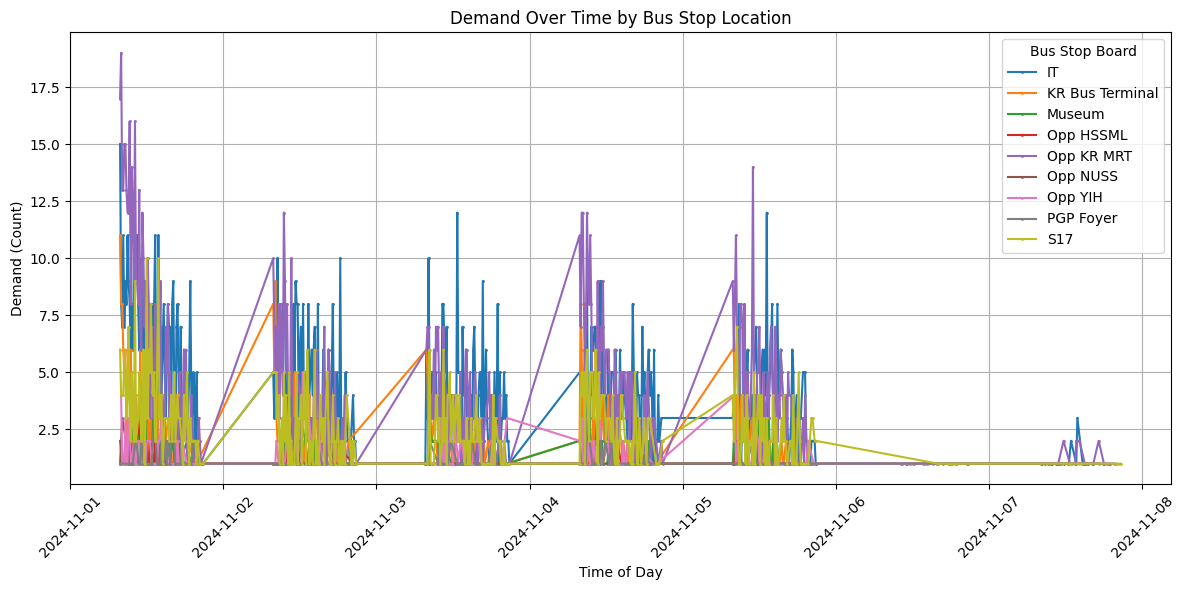

,bus_stop_board,time_start,count
0,IT,2024-11-01 07:50:00,15
1,IT,2024-11-01 08:00:00,8
2,IT,2024-11-01 08:10:00,7
3,IT,2024-11-01 08:20:00,11
4,IT,2024-11-01 08:30:00,7
...,...,...,...
2044,S17,2024-11-07 14:10:00,1
2045,S17,2024-11-07 14:30:00,1
2046,S17,2024-11-07 19:50:00,1
2047,S17,2024-11-07 20:20:00,1


In [27]:
# Proceed with the rest of your code
a1 = alldata[(alldata['ISB_Service'] == 'A2')]

a1_grouped = a1.groupby(['bus_stop_board', 'time_start']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(12, 6))
for bus_stop_board in a1_grouped['bus_stop_board'].unique():
    subset = a1_grouped[a1_grouped['bus_stop_board'] == bus_stop_board]
    plt.plot(subset['time_start'], subset['count'], label=bus_stop_board, marker='o', markersize=1)

# Configure plot labels and title
plt.title('Demand Over Time by Bus Stop Location')
plt.xlabel('Time of Day')
plt.ylabel('Demand (Count)')
plt.xticks(rotation=45)
plt.legend(title='Bus Stop Board')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

a1_grouped

# ARIMA

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error


### Check for stationary

In [18]:
def test_stationarity(timeseries):
    result = adfuller(timeseries['count'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

test_stationarity(a1_grouped)



ADF Statistic: -5.426021423893196
p-value: 2.98601232651768e-06
Critical Values:
	1%: -3.433586587734614
	5%: -2.8629697591275196
	10%: -2.5675311411427995
ADF Statistic: -5.426021423893196
p-value: 2.98601232651768e-06


Interpretation:
- ADF Statistic:
    The ADF statistic of -5.32 is significantly less than the critical values for all levels (1%, 5%, and 10%). This indicates strong evidence against the null hypothesis of non-stationarity.

- p-value:
    The p-value is approximately 0.0000049, which is far less than the common significance level of 0.05. This means we can reject the null hypothesis.

- Critical Values:
    The ADF statistic (-5.32) is less than the critical values:
    At the 1% level (-3.44)
    At the 5% level (-2.86)
    At the 10% level (-2.57)

Conclusion:
Since both the ADF statistic is less than the critical values at all significance levels and the p-value is less than 0.05, we reject the null hypothesis of non-stationarity. This means you can conclude that the time series is stationary. In the context of your analysis, this is a favorable outcome for applying ARIMA, as the model assumes the underlying time series data is stationary.

In [26]:
a1_grouped = a1_grouped[a1_grouped['bus_stop_board'] == 'Opp KR MRT']

train_size = int(len(a1_grouped) * 0.8)  # Use 80% for training
train, test = a1_grouped.iloc[:train_size], a1_grouped.iloc[train_size:]



model = auto_arima(train['count'], seasonal=False, stepwise=True)
print(model.summary())

from statsmodels.tsa.arima.model import ARIMA

# Assuming p, d, q are the determined parameters
p, d, q = model.order
arima_model = ARIMA(train['count'], order=(p, d, q))
arima_model_fit = arima_model.fit()

forecast = arima_model_fit.forecast(steps=len(test))

mse = mean_squared_error(test['count'], forecast)
print('Mean Squared Error:', mse)


plt.figure(figsize=(12, 6))
plt.plot(train.index, train['count'], label='Train')
plt.plot(test.index, test['count'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()



KeyboardInterrupt: 

c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is

Mean Squared Error: 14.129517385648189


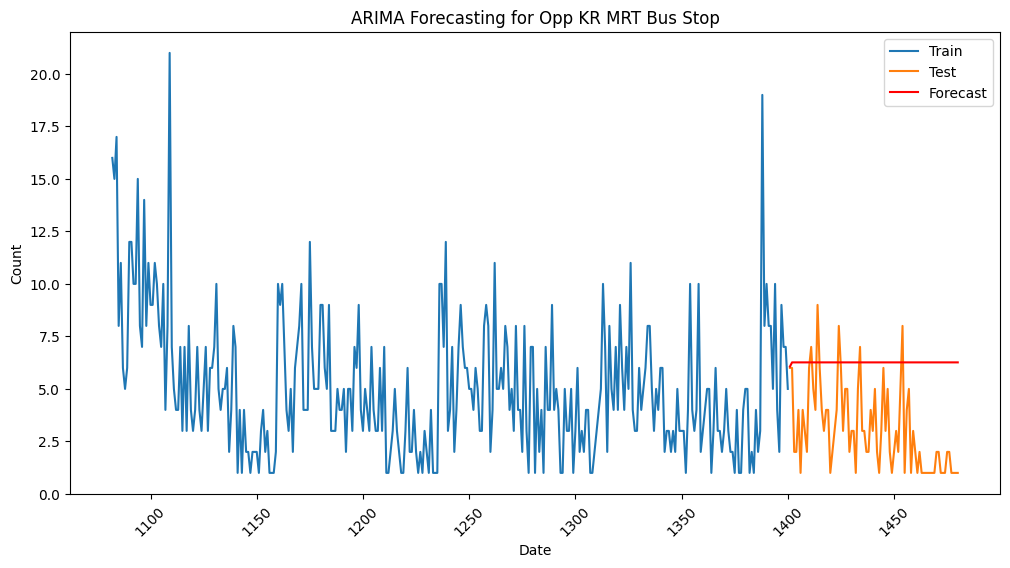

In [177]:
a1_grouped = a1_grouped[a1_grouped['bus_stop_board'] == 'Opp KR MRT']

train_size = int(len(a1_grouped) * 0.8)  # Use 80% for training
train, test = a1_grouped.iloc[:train_size], a1_grouped.iloc[train_size:]

# Fit ARIMA model
model = auto_arima(train['count'], seasonal=False, stepwise=True)
p, d, q = model.order
arima_model = ARIMA(train['count'], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Forecast
forecast = arima_model_fit.forecast(steps=len(test))

# Calculate Mean Squared Error
mse = mean_squared_error(test['count'], forecast)
print('Mean Squared Error:', mse)

# Plot with axis labels
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['count'], label='Train')
plt.plot(test.index, test['count'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')

# Set axis labels and title
plt.xlabel('Date')  # Customize to reflect your time index
plt.ylabel('Count')  # Count of boardings or alightings as per your data
plt.title('ARIMA Forecasting for Opp KR MRT Bus Stop')

# Rotate date labels for better readability, if needed
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Multivariate time series

In [24]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.vector_ar.var_model import VAR
tf.random.set_seed(99)
